In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import StadiaMapsTiles, OSM
import glob
from math import radians, sin, cos, asin, sqrt
import seaborn as sns
from matplotlib.ticker import NullFormatter
import pyproj
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.projections
import tskit
import re
import pyproj
import pandas as pd

In [2]:
import os
os.environ['CARTOPY_USER_SHAPEDIR'] = '/gpfs/fs1/home/m/mmosmond/oven/.local/share/cartopy'


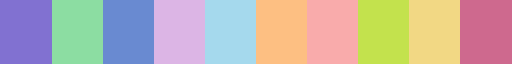

In [3]:
hex_colors = ['#8171d1', '#8cdda2', '#698ad1', '#dcb5e5', '#a5d9ed',
              '#fdbf82', '#f9abab', '#c3e24d','#f2d884', '#ce698e']

# Create a ListedColormap object
palette = ListedColormap(hex_colors, name = 'palette')
mpl.colormaps.register(cmap=palette, force=True)

palette

In [4]:
mle = np.load("data/pop_penguins_popsize_100nsamples_10000tCutoff_mle-dispersal.npy")
locations = np.load("penguinsrelate/matched_data_with_ids.npy", allow_pickle=True)
# locationss = np.load("penguinsrelate/matched_data.npy")
site_codes = locations[:, 0] 
longitudes = locations[:, 1].astype(float)
latitudes = locations[:, 2].astype(float)
unique_site_codes = np.unique(site_codes)

population_ixs = []
current_ix = 0
for code in unique_site_codes:
    indices = np.where(site_codes == code)[0]
    population_ixs.extend([current_ix] * len(indices))
    current_ix += 1

population_ixs = np.array(population_ixs)

ids_file = "penguinsrelate/matched_data_with_ids.csv"
df = pd.read_csv(ids_file)
ids = df['Site Code'].tolist()

In [5]:
mle

array([0.05255944, 0.03075978, 0.76199252, 0.00182303])

In [6]:
m = '1.5e-8' #prior mutation rate
nsamples = 100 #number of trees per locus
tCutoff = int(1e4)
max_time = tCutoff
ancestor_times = np.logspace(1,np.log10(max_time),10)

In [7]:
fnss = []

CHRS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


for CHR in CHRS:
    string = 'data/pop_penguins_popsize_chr%d_' % CHR + '*bps_%dnsamples_%dtCutoff_anc-locs.npy' % (nsamples, tCutoff)
    fns = sorted(glob.glob(string))
    
    starts = [int(re.search(r'chr%d_(\d+)' % CHR, fn).group(1)) for fn in fns]
    locus_order = np.argsort(starts)
    fnss.append([fns[i] for i in locus_order])

fns = [fn for fns in fnss for fn in fns]

anc_locs = []
for fn in fns:
    anc_locs.append(np.load(fn))

anc_locs = np.array(anc_locs)
#anc_locs[..., [0, 1]] = anc_locs[..., [1, 0]]

L, n, T, d = anc_locs.shape
L, n, T, d

(1869, 238, 11, 2)

In [8]:
meanlat = np.mean(locations[:,2])
meanlat

-64.66085041937924

In [9]:
long = mle[0]**2 * (np.cos(meanlat * np.pi/180)*111)**2 
lat = mle[1]**2 * 111**2 
long, lat

(6.234264724641511, 11.657684341002103)

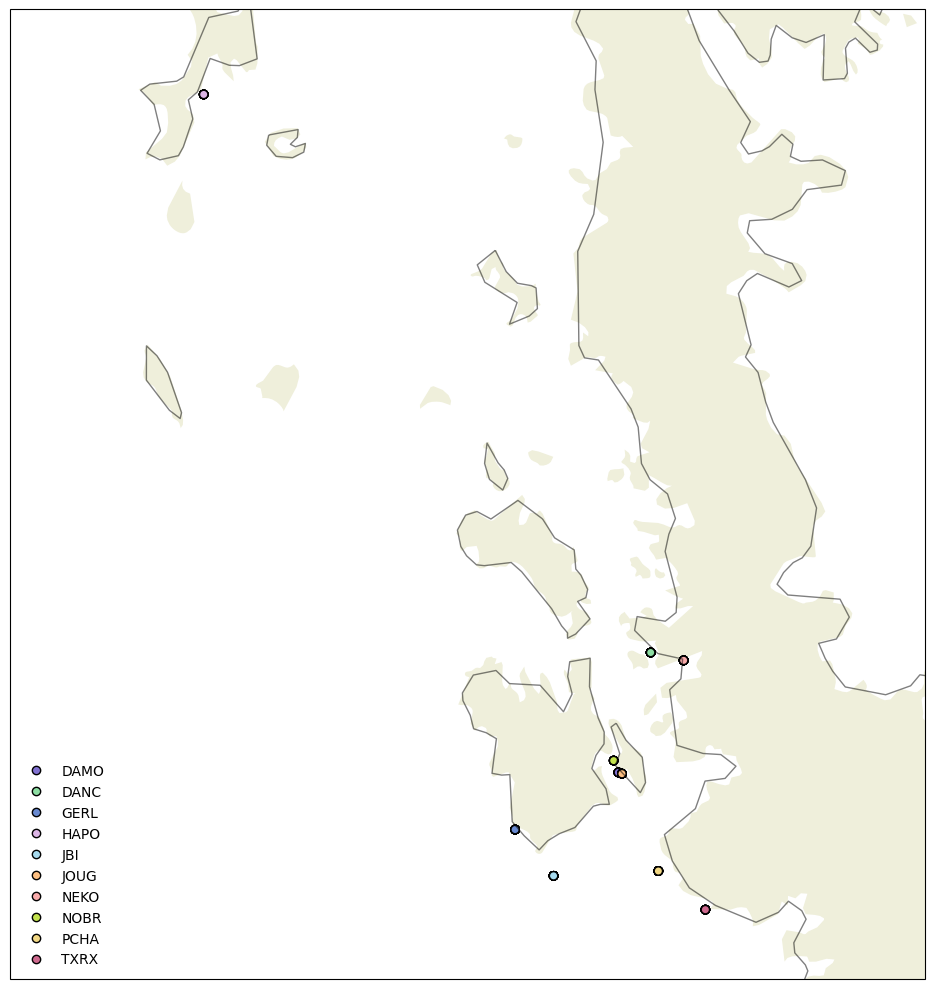

In [13]:
extent = [-65, -59.5, -65, -63]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())
ax.set_extent(extent)

cmap = palette
ax.scatter(locations[:,1], locations[:,2], transform=ccrs.PlateCarree(), color=cmap(population_ixs), edgecolor='k', zorder=1)
ax.coastlines(resolution='50m', alpha=0.5)
ax.add_feature(cfeature.LAND, alpha=1)

handles = [plt.Line2D((0,1),(0,0), color=cmap(i), marker='o', linestyle='', markeredgecolor='k') for i in range(10)]
plt.legend(handles, unique_site_codes, loc='lower left', frameon=False)

plt.tight_layout()
# plt.savefig(plotdir + 'locations.pdf')
plt.show()

In [14]:
locations[0, 1:]

array([-63.49680000815988, -64.81490000077463], dtype=object)

In [10]:
time_ix = 5

disps = []

for sample in range(n):
    locs = anc_locs[:, sample, time_ix]
    mean_loc = np.mean(locs, axis=0)
    disp = mean_loc - locations[sample, 1:]
    disps.append(disp)

In [14]:
mean_loc

array([-63.72082442, -64.94419031])

In [11]:
def haversine(loc1, loc2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [loc1[0], loc1[1], loc2[0], loc2[1]])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [18]:
dists = [haversine(locations[i, 1:], locations[i, 1:]+disp) for i,disp in enumerate(disps)]
relative_dists = dists/np.max(dists)

In [19]:
np.min(dists)

6.658862197766045

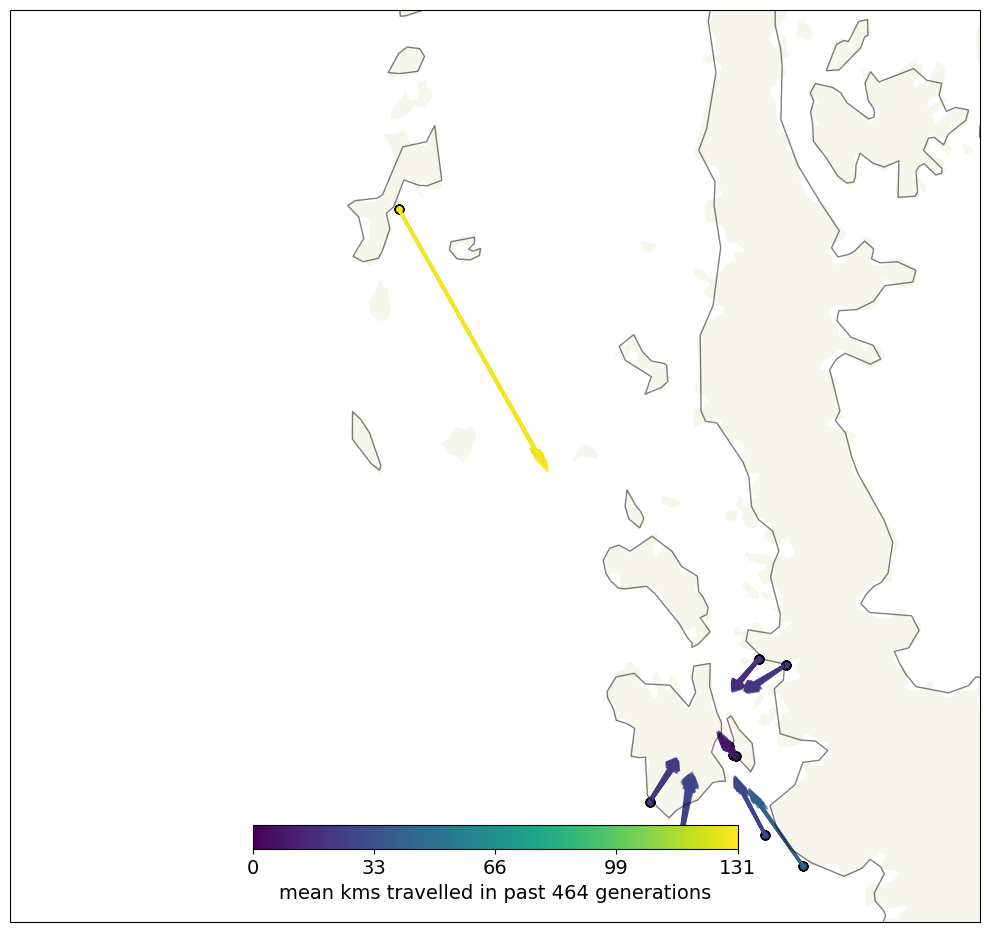

In [22]:
extent = [-65, -59.5, -65, -62]
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())
ax.set_extent(extent)
    
for i,disp in enumerate(disps):
    
    cmap = plt.get_cmap('viridis')
    color = cmap(relative_dists[i])
#     color = plt.cm.tab10(population_ixs[i])
    ax.scatter(locations[i,1], locations[i,2], transform=ccrs.PlateCarree(), color=color, edgecolor='k', zorder=0)
    ax.arrow(locations[i,1], locations[i,2], disp[0], disp[1], transform=ccrs.PlateCarree(),
             head_width=0.05, length_includes_head=True, width=0.01, alpha=0.5, color=color)

ax.coastlines(resolution='50m', alpha=0.5)
ax.add_feature(cfeature.LAND, alpha=0.5)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=-0.1, shrink=0.5)
cbar.set_ticks([i/4 for i in range(5)])
cbar.set_ticklabels([round(i*max(dists)/4) for i in range(5)])
cbar.set_label('mean kms travelled in past %d generations' %int(ancestor_times[time_ix]), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()

plt.show()

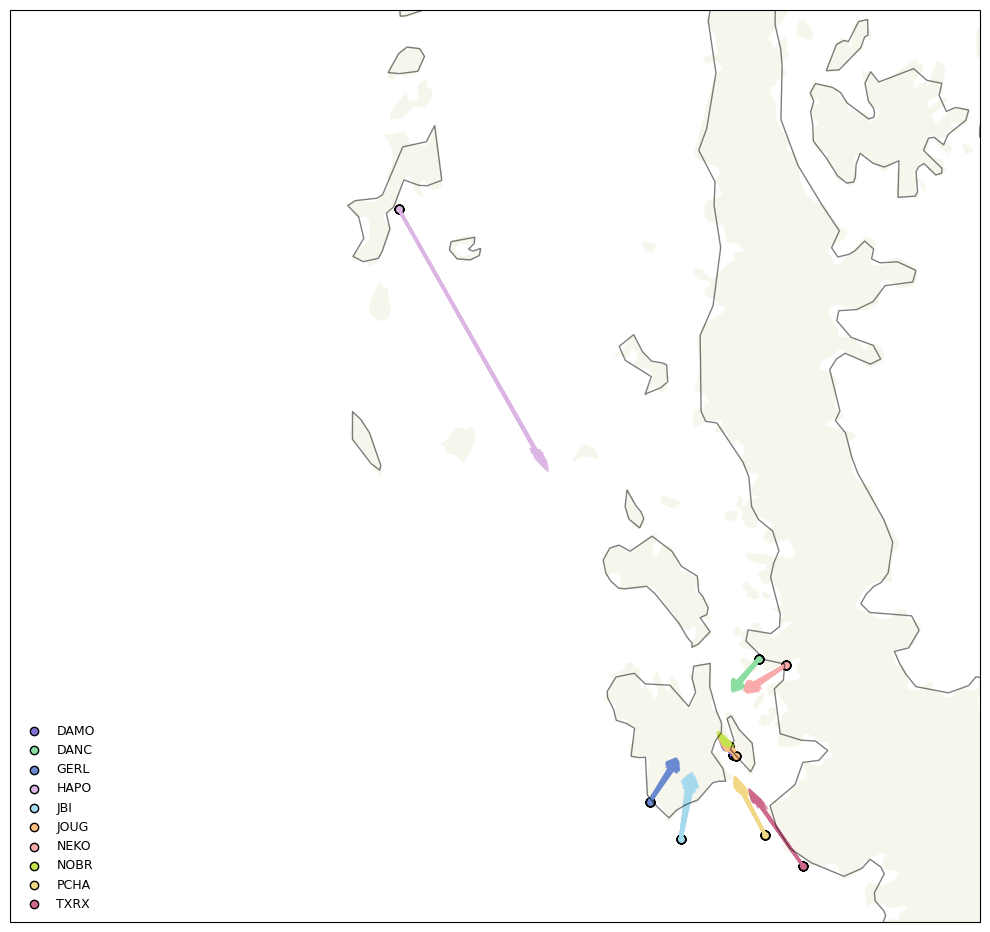

In [60]:
extent = [-65, -59.5, -65, -62]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())
ax.set_extent(extent)
    
for i,disp in enumerate(disps):
    
    color = palette(population_ixs[i])
    ax.scatter(locations[i,1], locations[i,2], transform=ccrs.PlateCarree(), color=color, edgecolor='k', zorder=0, label=locations[i,0])
    ax.arrow(locations[i,1], locations[i,2], disp[0], disp[1], transform=ccrs.PlateCarree(),
             head_width=0.05, length_includes_head=True, width=0.01, alpha=0.5, color=color)

ax.coastlines(resolution='50m', alpha=0.5)
ax.add_feature(cfeature.LAND, alpha=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower left', frameon=False, fontsize=9)

plt.tight_layout()

plt.show()

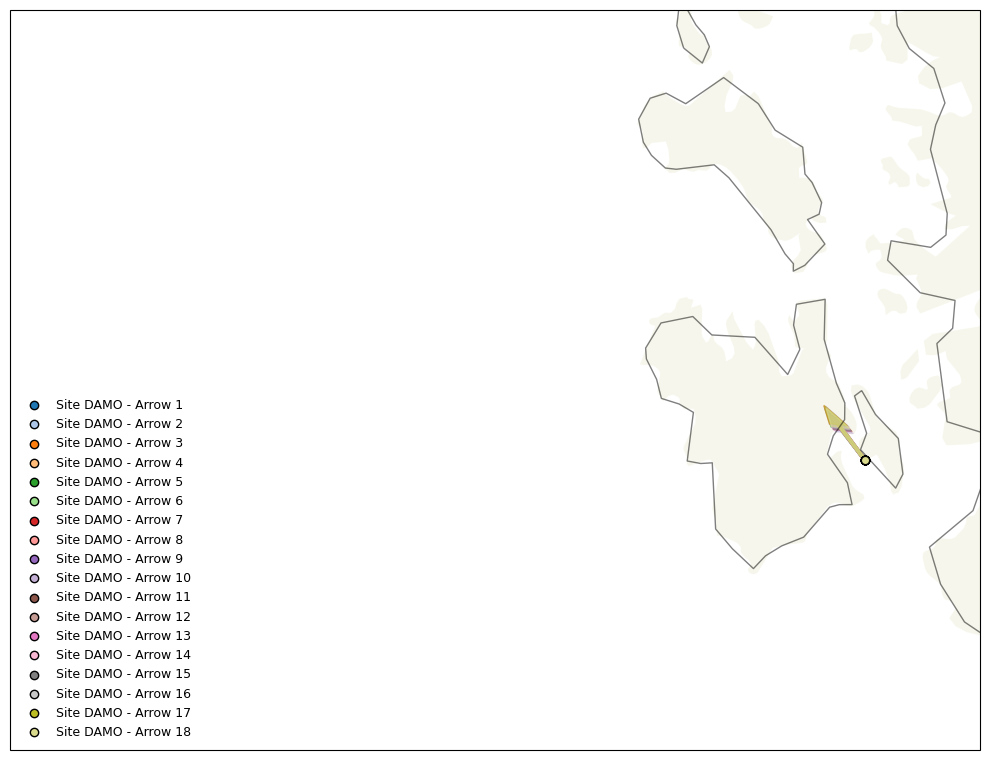

In [36]:
site_id = 'DAMO'  # ID of the site to focus on

indices = np.where(locations[:, 0] == site_id)[0]

extent = [-65, -63, -65, -63]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Plot arrows for the specific site based on indices
for idx in indices:
    location = locations[idx]
    disp = disps[idx]
    color = plt.cm.tab20(idx)  
    ax.scatter(location[1], location[2], transform=ccrs.PlateCarree(), color=color, edgecolor='k', zorder=10, label=f'Site {location[0]} - Arrow {idx+1}')
    ax.arrow(location[1], location[2], disp[0], disp[1], transform=ccrs.PlateCarree(),
             head_width=0.05, length_includes_head=True, width=0.01, alpha=0.5, color=color)

ax.coastlines(resolution='50m', alpha=0.5)
ax.add_feature(cfeature.LAND, alpha=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower left', frameon=False, fontsize=9)

plt.tight_layout()
plt.show()

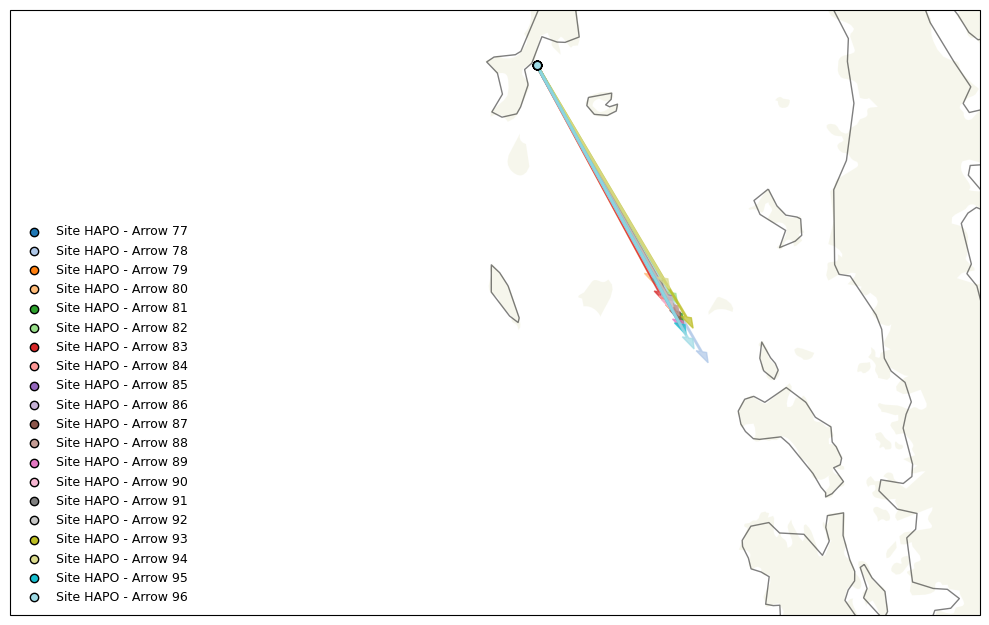

In [404]:
site_id = 'HAPO'  

indices = np.where(locations[:, 0] == site_id)[0]

extent = [-63.4, -62, -65, -61]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, crs=ccrs.PlateCarree())

for i, idx in enumerate(indices):
    location = locations[idx]
    disp = disps[idx]
    color = plt.cm.tab20(i % cmap.N)  
    ax.scatter(location[1], location[2], transform=ccrs.PlateCarree(), color=color, edgecolor='k', zorder=10, label=f'Site {location[0]} - Arrow {idx+1}')
    ax.arrow(location[1], location[2], disp[0], disp[1], transform=ccrs.PlateCarree(),
             head_width=0.05, length_includes_head=True, width=0.01, alpha=0.7, color=color)

ax.coastlines(resolution='50m', alpha=0.5)
ax.add_feature(cfeature.LAND, alpha=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower left', frameon=False, fontsize=9)

plt.tight_layout()
plt.show()

In [53]:
cmaps = [deeppurp_colormap, green_colormap, blue_colormap, lavender_colormap, sky_colormap, orange_colormap,
         coral_colormap, lime_colormap, yellow_colormap, ruby_colormap]

def ancestor_clouds(sample, extent=None, time_ixs = range(8,11), levels=10, bw_adjust=1, filename=None):
    
    cmap = cmaps[population_ixs[sample]]

    fig, axs = plt.subplots(1,len(time_ixs),figsize=(5*len(time_ixs), 5),subplot_kw={'projection': ccrs.SouthPolarStereo()})

    print(locations[sample])
    for ax,time_ix in zip(axs,time_ixs):
        cmap = palette
        print(int(ancestor_times[time_ix]))
        
        locs = anc_locs[:,sample,time_ix]
#         row_mask = (locs != locations[sample]).all(axis=1)
#         locs = locs[row_mask,:] #exclude subtrees that contain only the sample
    
        sns.kdeplot(x=locs[:,0], y=locs[:,1], transform=ccrs.PlateCarree(), ax=ax, levels=levels, color=palette(population_ixs[sample]), bw_adjust=bw_adjust, zorder=0)#fill=True, , cmap=cmap
        ax.scatter(locs[:,0], locs[:,1], transform=ccrs.PlateCarree(), color=palette(population_ixs[sample]), alpha=0.1)

        ax.scatter(locations[sample,1], locations[sample,2], transform=ccrs.PlateCarree(), color=palette(population_ixs[sample]), edgecolor='k')
#         ax.scatter(locations[:,0], locations[:,1], transform=ccrs.PlateCarree(), color=plt.cm.tab10(population_ixs), alpha=0.1)
        ax.scatter(locations[:,1], locations[:,2], transform=ccrs.PlateCarree(), color=cmap(population_ixs), edgecolor='k', zorder=0.1, alpha = 0.7)
        

        
#         ax.set_title(int(ancestor_times[time_ix]))
        ax.coastlines(resolution='50m', alpha=0.5)
        ax.add_feature(cfeature.LAND, alpha=0.5)
        
        legend_ax = fig.add_axes([0.1, -0.1, 0.8, 0.1])
        legend_ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
        handles = [plt.Line2D((0,1),(0,0), color=cmap(i), marker='o', linestyle='', markeredgecolor='k') for i in range(10)]
        legend_ax.legend(handles, unique_site_codes, loc='center', frameon=False, ncol=len(unique_site_codes)//2)
        
        if extent is not None:
            ax.set_extent(extent, crs=ccrs.PlateCarree())

    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename)
    plt.show()

['NEKO' -62.532699996251445 -64.83829999660374]
21
464
10000


/tmp/ipykernel_282227/81934469.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


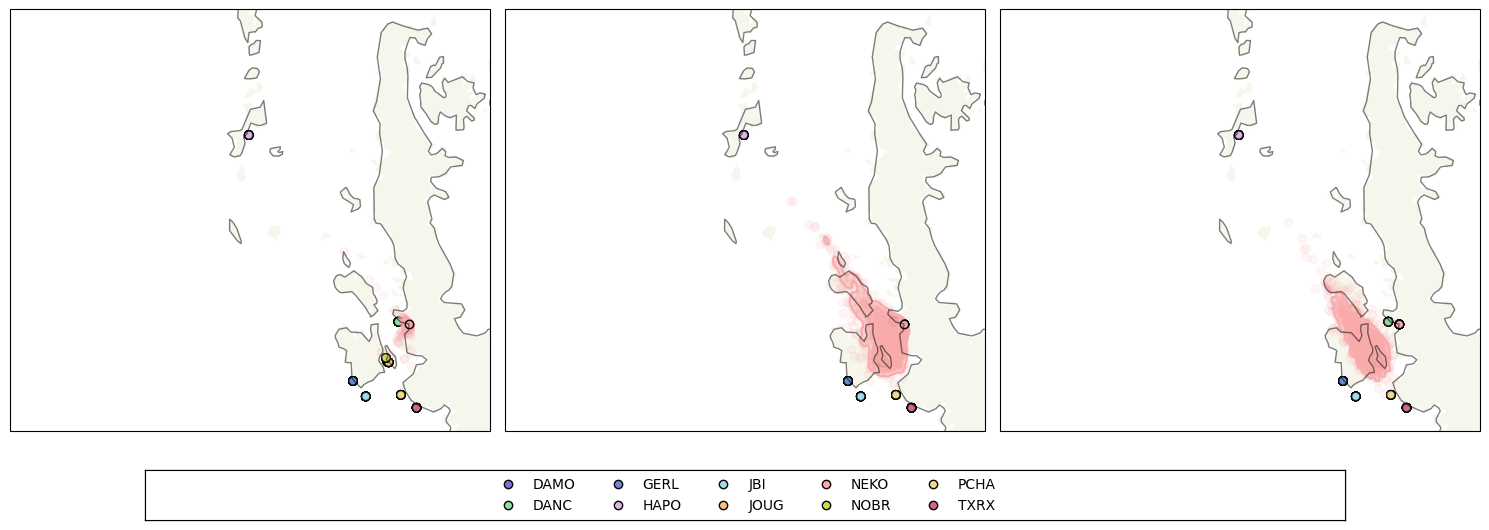

In [54]:
extent = [-65, -59.5, -65, -61.2]
filename = None  
ancestor_clouds(175, extent=extent, bw_adjust=0.65, time_ixs=[1, 5, 9], filename=filename)

['HAPO' -60.61339999372108 -62.65450000019254]
21
464
10000


/tmp/ipykernel_282227/81934469.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


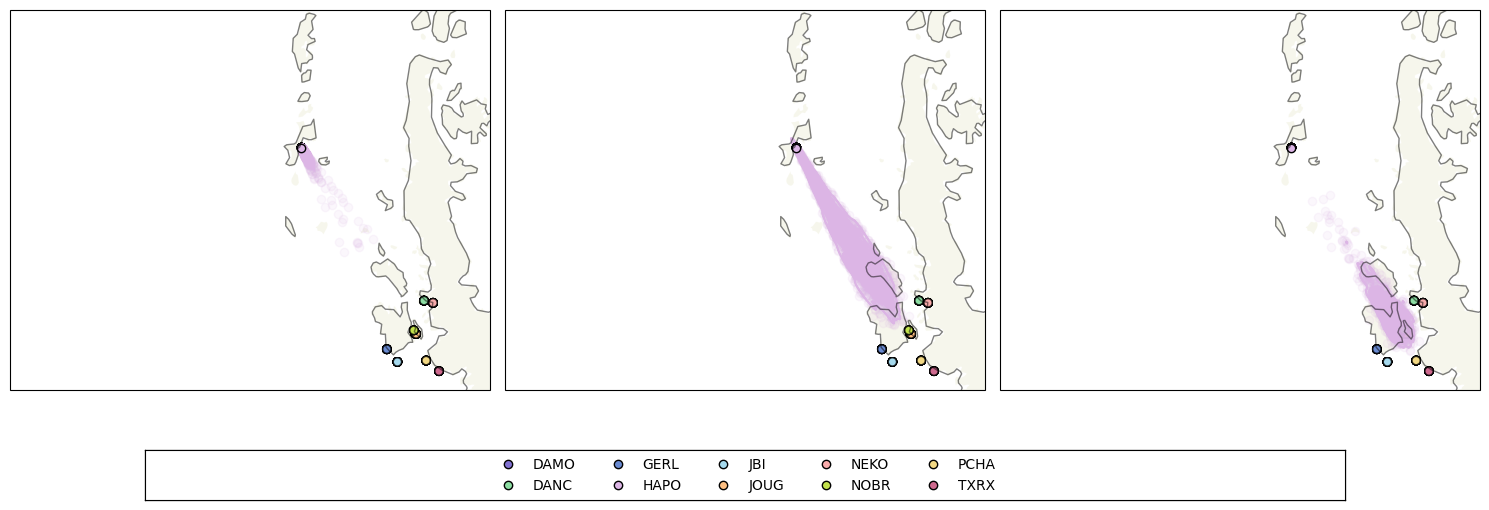

In [55]:
extent = [-65, -60, -65, -60]
filename = None  
ancestor_clouds(95, extent=extent, bw_adjust=0.65, time_ixs=[1, 5, 9], filename=filename)

In [282]:
np.count_nonzero(population_ixs == 1)

30

In [347]:
locations[sample,0], locations[sample,1]

('TXRX', -64.1333999946784)

In [288]:
ancestor_times

array([   10.        ,    21.5443469 ,    46.41588834,   100.        ,
         215.443469  ,   464.15888336,  1000.        ,  2154.43469003,
        4641.58883361, 10000.        ])

In [52]:
deeppurp = np.array([[255,255,255], [254,254,255], [253,254,255], [252,253,255], [252,252,255], [251,252,255], [250,251,254], [249,251,254], [248,250,254], [247,249,254], [247,249,254], [246,248,254], [245,247,254], [244,247,254], [243,246,254], [242,245,254], [241,245,253], [241,244,253], [240,243,253], [239,243,253], [238,242,253], [237,242,253], [236,241,253], [235,240,253], [235,240,253], [234,239,253], [233,238,252], [232,238,252], [231,237,252], [230,236,252], [230,236,252], [229,235,252], [228,234,252], [227,234,252], [226,233,252], [225,233,252], [224,232,252], [224,231,251], [223,231,251], [222,230,251], [221,229,251], [220,229,251], [219,228,251], [219,227,251], [218,227,251], [217,226,251], [216,225,251], [215,225,250], [214,224,250], [213,224,250], [213,223,250], [212,222,250], [211,222,250], [210,221,250], [209,220,250], [208,220,250], [207,219,250], [207,218,249], [206,218,249], [205,217,249], [204,216,249], [203,216,249], [202,215,249], [202,215,249], [201,214,249], [200,213,248], [200,212,248], [199,211,247], [199,210,247], [198,209,246], [198,208,245], [198,207,245], [197,206,244], [197,206,244], [196,205,243], [196,204,243], [195,203,242], [195,202,242], [194,201,241], [194,200,241], [193,199,240], [193,198,239], [193,197,239], [192,196,238], [192,195,238], [191,194,237], [191,194,237], [190,193,236], [190,192,236], [189,191,235], [189,190,235], [188,189,234], [188,188,233], [187,187,233], [187,186,232], [187,185,232], [186,184,231], [186,183,231], [185,182,230], [185,182,230], [184,181,229], [184,180,229], [183,179,228], [183,178,227], [182,177,227], [182,176,226], [181,175,226], [181,174,225], [181,173,225], [180,172,224], [180,171,224], [179,171,223], [179,170,223], [178,169,222], [178,168,221], [177,167,221], [177,166,220], [176,165,220], [176,164,219], [175,163,219], [175,162,218], [175,161,218], [174,160,217], [174,159,217], [173,159,216], [173,158,215], [172,157,215], [172,156,214], [171,155,214], [169,153,213], [168,151,213], [167,150,212], [165,148,212], [164,146,211], [163,145,211], [161,143,210], [160,142,209], [158,140,209], [157,138,208], [156,137,208], [154,135,207], [153,133,207], [152,132,206], [150,130,206], [149,129,205], [147,127,205], [146,125,204], [145,124,203], [143,122,203], [142,120,202], [140,119,202], [139,117,201], [138,116,201], [136,114,200], [135,112,200], [134,111,199], [132,109,199], [131,107,198], [129,106,197], [128,104,197], [127,103,196], [125,101,196], [124,99,195], [122,98,195], [121,96,194], [120,94,194], [118,93,193], [117,91,193], [116,90,192], [114,88,191], [113,86,191], [111,85,190], [110,83,190], [109,81,189], [107,80,189], [106,78,188], [105,77,188], [103,75,187], [102,73,187], [100,72,186], [99,70,185], [98,68,185], [96,67,184], [95,65,184], [93,64,183], [92,62,183], [91,60,182], [89,59,182], [88,57,181], [87,55,181], [85,54,180], [84,52,179], [83,52,179], [83,52,179], [83,52,179], [83,52,178], [83,52,178], [83,52,178], [83,52,177], [83,51,177], [83,51,177], [83,51,177], [83,51,176], [82,51,176], [82,51,176], [82,51,175], [82,51,175], [82,51,175], [82,51,175], [82,51,174], [82,51,174], [82,51,174], [82,51,173], [82,51,173], [82,51,173], [81,51,173], [81,51,172], [81,51,172], [81,51,172], [81,51,172], [81,51,171], [81,51,171], [81,51,171], [81,51,170], [81,51,170], [81,51,170], [81,51,170], [80,50,169], [80,50,169], [80,50,169], [80,50,168], [80,50,168], [80,50,168], [80,50,168], [80,50,167], [80,50,167], [80,50,167], [80,50,167], [79,50,166], [79,50,166], [79,50,166], [79,50,165], [79,50,165], [79,50,165], [79,50,165], [79,50,164], [79,50,164], [79,50,164], [79,50,163], [79,50,163], [78,50,163], [78,50,163], [78,50,162], [78,50,162], [78,49,162], [78,49,162]])
deeppurp_normalized = deeppurp / 255.0
deeppurp_colormap = mcolors.ListedColormap(deeppurp_normalized, name = 'deeppurp_normalized')
np.save('deeppurp_colormap.npy', deeppurp_normalized)

orange = np.array([[255,255,255], [255,255,253], [255,254,251], [255,254,249], [255,253,247], [255,253,245], [255,253,243], [255,252,241], [255,252,239], [255,251,236], [255,251,234], [255,251,232], [255,250,230], [255,250,228], [255,249,226], [255,249,224], [255,249,222], [255,248,220], [255,248,218], [255,247,216], [255,247,214], [255,247,212], [255,246,210], [255,246,208], [255,245,206], [255,245,203], [255,245,201], [255,244,199], [255,244,197], [255,243,195], [255,243,193], [255,243,191], [255,242,189], [255,242,187], [255,241,185], [255,241,183], [255,241,181], [255,240,179], [255,240,177], [255,239,175], [255,239,173], [255,239,171], [255,238,168], [255,238,166], [255,237,164], [255,237,162], [255,237,160], [255,236,158], [255,236,156], [255,235,154], [255,235,152], [255,235,150], [255,234,148], [255,234,146], [255,233,144], [255,233,142], [255,233,140], [255,232,138], [255,232,135], [255,231,133], [255,231,131], [255,231,129], [255,230,127], [255,230,125], [255,229,123], [255,229,121], [255,228,119], [255,228,117], [255,227,115], [255,227,113], [255,226,112], [255,226,110], [255,226,108], [255,225,106], [255,225,104], [255,224,102], [255,224,100], [255,223,98], [254,223,96], [254,222,94], [254,222,92], [254,221,90], [254,221,88], [254,220,86], [254,220,84], [254,219,82], [254,219,80], [254,218,79], [254,218,77], [254,217,75], [254,217,73], [254,216,71], [254,216,69], [254,215,67], [254,215,65], [254,214,63], [254,214,61], [254,213,59], [254,213,57], [254,212,55], [254,212,53], [254,211,51], [254,211,49], [254,210,48], [254,210,46], [254,210,44], [253,209,42], [253,209,40], [253,208,38], [253,208,36], [253,207,34], [253,207,32], [253,206,30], [253,206,28], [253,205,26], [253,205,24], [253,204,22], [253,204,20], [253,203,18], [253,203,16], [253,202,15], [253,202,13], [253,201,11], [253,201,9], [253,200,7], [253,200,5], [253,199,3], [253,199,1], [253,198,0], [252,197,0], [252,196,1], [252,195,1], [252,194,1], [251,193,2], [251,192,2], [251,191,2], [251,190,2], [250,189,3], [250,188,3], [250,187,3], [250,186,4], [249,186,4], [249,185,4], [249,184,5], [248,183,5], [248,182,5], [248,181,5], [248,180,6], [247,179,6], [247,178,6], [247,177,7], [247,176,7], [246,175,7], [246,174,7], [246,173,8], [246,172,8], [245,171,8], [245,170,9], [245,169,9], [245,168,9], [244,167,9], [244,166,10], [244,165,10], [244,164,10], [243,163,11], [243,162,11], [243,161,11], [243,160,11], [242,159,12], [242,158,12], [242,157,12], [242,156,13], [241,155,13], [241,154,13], [241,153,14], [241,153,14], [240,152,14], [240,151,14], [240,150,15], [240,149,15], [239,148,15], [239,147,16], [239,146,16], [239,145,16], [238,144,16], [238,143,17], [238,142,17], [238,141,17], [237,140,18], [237,139,18], [237,138,18], [237,137,18], [236,137,19], [236,137,19], [236,137,19], [236,136,20], [236,136,20], [236,136,20], [236,136,20], [236,136,21], [236,136,21], [236,136,21], [236,136,21], [236,136,22], [236,136,22], [236,135,22], [236,135,22], [236,135,23], [236,135,23], [236,135,23], [236,135,23], [235,135,24], [235,135,24], [235,135,24], [235,135,24], [235,134,25], [235,134,25], [235,134,25], [235,134,25], [235,134,26], [235,134,26], [235,134,26], [235,134,26], [235,134,27], [235,134,27], [235,133,27], [235,133,27], [235,133,28], [235,133,28], [235,133,28], [235,133,28], [235,133,29], [234,133,29], [234,133,29], [234,133,29], [234,133,30], [234,132,30], [234,132,30], [234,132,30], [234,132,31], [234,132,31], [234,132,31], [234,132,31], [234,132,32], [234,132,32], [234,132,32], [234,131,32], [234,131,33], [234,131,33], [234,131,33], [234,131,34], [234,131,34], [234,131,34], [233,131,34], [233,131,35], [233,131,35]])

orange_normalized = orange / 255.0
orange_colormap = mcolors.ListedColormap(orange_normalized, name = 'orange_colormap')
np.save('orange_colormap.npy', orange_normalized)

#Blue
blue = np.array([[255,255,255], [253,254,255], [251,253,254], [249,252,254], [247,251,254], [245,250,253], [243,249,253], [241,249,253], [239,248,252], [236,247,252], [234,246,252], [232,245,251], [230,244,251], [228,243,251], [226,242,250], [224,241,250], [222,240,250], [220,239,249], [218,238,249], [216,237,249], [214,237,248], [212,236,248], [210,235,248], [208,234,247], [206,233,247], [203,232,247], [201,231,246], [199,230,246], [197,229,245], [195,228,245], [193,227,245], [191,226,244], [189,226,244], [187,225,244], [185,224,243], [183,223,243], [181,222,243], [179,221,242], [177,220,242], [175,219,242], [173,218,241], [171,217,241], [168,216,241], [166,215,240], [164,214,240], [162,214,240], [160,213,239], [158,212,239], [156,211,239], [154,210,238], [152,209,238], [150,208,238], [148,207,237], [146,206,237], [144,205,237], [142,204,236], [140,203,236], [138,202,236], [135,202,235], [133,201,235], [131,200,235], [129,199,234], [127,198,234], [125,197,234], [123,196,233], [122,195,233], [121,195,233], [120,194,233], [119,193,233], [118,193,233], [117,192,233], [116,191,232], [115,191,232], [114,190,232], [113,189,232], [112,189,232], [111,188,232], [110,187,232], [109,187,232], [108,186,232], [107,185,231], [106,185,231], [105,184,231], [104,183,231], [103,183,231], [102,182,231], [101,181,231], [100,180,231], [99,180,230], [98,179,230], [97,178,230], [96,178,230], [95,177,230], [94,176,230], [93,176,230], [92,175,230], [91,174,229], [90,174,229], [89,173,229], [88,172,229], [87,172,229], [86,171,229], [85,170,229], [84,170,229], [83,169,228], [82,168,228], [81,168,228], [80,167,228], [79,166,228], [78,166,228], [77,165,228], [76,164,228], [75,164,228], [74,163,227], [73,162,227], [72,161,227], [71,161,227], [70,160,227], [69,159,227], [68,159,227], [67,158,227], [66,157,226], [65,157,226], [64,156,226], [63,155,226], [62,155,226], [61,154,226], [60,153,226], [59,153,226], [59,152,225], [58,152,225], [57,151,225], [57,151,225], [56,150,225], [55,149,224], [55,149,224], [54,148,224], [53,148,224], [53,147,223], [52,147,223], [51,146,223], [51,146,223], [50,145,223], [50,145,222], [49,144,222], [48,143,222], [48,143,222], [47,142,222], [46,142,221], [46,141,221], [45,141,221], [44,140,221], [44,140,221], [43,139,220], [42,139,220], [42,138,220], [41,137,220], [41,137,220], [40,136,219], [39,136,219], [39,135,219], [38,135,219], [37,134,219], [37,134,218], [36,133,218], [35,133,218], [35,132,218], [34,131,217], [33,131,217], [33,130,217], [32,130,217], [32,129,217], [31,129,216], [30,128,216], [30,128,216], [29,127,216], [28,127,216], [28,126,215], [27,125,215], [26,125,215], [26,124,215], [25,124,215], [24,123,214], [24,123,214], [23,122,214], [23,122,214], [22,121,214], [21,121,213], [21,120,213], [20,119,213], [19,119,213], [19,118,213], [19,118,213], [19,118,213], [19,118,213], [20,118,213], [20,118,213], [20,118,213], [20,118,213], [21,118,213], [21,118,213], [21,118,213], [21,117,213], [22,117,213], [22,117,213], [22,117,213], [22,117,213], [23,117,213], [23,117,214], [23,117,214], [23,117,214], [24,117,214], [24,117,214], [24,117,214], [24,117,214], [25,116,214], [25,116,214], [25,116,214], [25,116,214], [26,116,214], [26,116,214], [26,116,214], [26,116,214], [27,116,214], [27,116,214], [27,116,215], [27,116,215], [28,116,215], [28,116,215], [28,115,215], [28,115,215], [29,115,215], [29,115,215], [29,115,215], [29,115,215], [30,115,215], [30,115,215], [30,115,215], [30,115,215], [31,115,215], [31,115,215], [31,115,216], [31,115,216], [32,114,216], [32,114,216], [32,114,216], [32,114,216], [33,114,216], [33,114,216], [33,114,216], [34,114,216], [34,114,216], [34,114,216], [34,114,216], [35,114,216], [35,114,216]])

# Green
green = np.array([[255,255,255], [253,255,254], [251,255,253], [249,254,252], [247,254,251], [245,254,250], [243,254,249], [241,253,249], [239,253,248], [236,253,247], [234,253,246], [232,253,245], [230,252,244], [228,252,243], [226,252,242], [224,252,241], [222,252,240], [220,251,239], [218,251,238], [216,251,237], [214,251,237], [212,250,236], [210,250,235], [208,250,234], [206,250,233], [203,250,232], [201,249,231], [199,249,230], [197,249,229], [195,249,228], [193,248,227], [191,248,226], [189,248,226], [187,248,225], [185,248,224], [183,247,223], [181,247,222], [179,247,221], [177,247,220], [175,246,219], [173,246,218], [171,246,217], [168,246,216], [166,246,215], [164,245,214], [162,245,214], [160,245,213], [158,245,212], [156,245,211], [154,244,210], [152,244,209], [150,244,208], [148,244,207], [146,243,206], [144,243,205], [142,243,204], [140,243,203], [138,243,202], [135,242,202], [133,242,201], [131,242,200], [129,242,199], [127,241,198], [125,241,197], [123,241,196], [122,241,195], [121,241,195], [120,240,194], [119,240,193], [118,240,193], [117,240,192], [116,239,191], [115,239,191], [114,239,190], [113,239,189], [112,238,189], [111,238,188], [110,238,187], [109,238,187], [108,237,186], [107,237,185], [106,237,185], [105,237,184], [104,236,183], [103,236,183], [102,236,182], [101,236,181], [100,235,180], [99,235,180], [98,235,179], [97,235,178], [96,234,178], [95,234,177], [94,234,176], [93,234,176], [92,234,175], [91,233,174], [90,233,174], [89,233,173], [88,233,172], [87,232,172], [86,232,171], [85,232,170], [84,232,170], [83,231,169], [82,231,168], [81,231,168], [80,231,167], [79,230,166], [78,230,166], [77,230,165], [76,230,164], [75,229,164], [74,229,163], [73,229,162], [72,229,161], [71,228,161], [70,228,160], [69,228,159], [68,228,159], [67,227,158], [66,227,157], [65,227,157], [64,227,156], [63,226,155], [62,226,155], [61,226,154], [60,226,153], [59,225,153], [59,225,152], [58,225,152], [57,224,151], [57,224,151], [56,223,150], [55,223,149], [55,223,149], [54,222,148], [53,222,148], [53,221,147], [52,221,147], [51,220,146], [51,220,146], [50,220,145], [50,219,145], [49,219,144], [48,218,143], [48,218,143], [47,218,142], [46,217,142], [46,217,141], [45,216,141], [44,216,140], [44,216,140], [43,215,139], [42,215,139], [42,214,138], [41,214,137], [41,213,137], [40,213,136], [39,213,136], [39,212,135], [38,212,135], [37,211,134], [37,211,134], [36,211,133], [35,210,133], [35,210,132], [34,209,131], [33,209,131], [33,209,130], [32,208,130], [32,208,129], [31,207,129], [30,207,128], [30,206,128], [29,206,127], [28,206,127], [28,205,126], [27,205,125], [26,204,125], [26,204,124], [25,204,124], [24,203,123], [24,203,123], [23,202,122], [23,202,122], [22,202,121], [21,201,121], [21,201,120], [20,200,119], [19,200,119], [19,199,118], [19,199,118], [19,199,118], [19,198,118], [20,198,118], [20,198,118], [20,197,118], [20,197,118], [21,197,118], [21,196,118], [21,196,118], [21,195,117], [22,195,117], [22,195,117], [22,194,117], [22,194,117], [23,194,117], [23,193,117], [23,193,117], [23,193,117], [24,192,117], [24,192,117], [24,191,117], [24,191,117], [25,191,116], [25,190,116], [25,190,116], [25,190,116], [26,189,116], [26,189,116], [26,189,116], [26,188,116], [27,188,116], [27,187,116], [27,187,116], [27,187,116], [28,186,116], [28,186,116], [28,186,115], [28,185,115], [29,185,115], [29,185,115], [29,184,115], [29,184,115], [30,183,115], [30,183,115], [30,183,115], [30,182,115], [31,182,115], [31,182,115], [31,181,115], [31,181,115], [32,181,114], [32,180,114], [32,180,114], [32,179,114], [33,179,114], [33,179,114], [33,178,114], [34,178,114], [34,178,114], [34,177,114], [34,177,114], [35,177,114], [35,176,114]])

# Sky
sky = np.array([[255,255,255], [254,255,255], [253,255,255], [252,255,255], [252,255,255], [251,255,255], [250,255,255], [249,255,255], [248,255,255], [247,255,255], [246,255,255], [245,255,255], [245,255,255], [244,255,255], [243,255,255], [242,255,255], [241,255,255], [240,255,255], [239,255,255], [238,255,255], [238,255,255], [237,254,255], [236,254,255], [235,254,255], [234,254,255], [233,254,255], [232,254,255], [231,254,255], [231,254,255], [230,254,255], [229,254,255], [228,254,255], [227,254,255], [226,254,255], [225,254,255], [224,254,255], [224,254,255], [223,254,255], [222,254,255], [221,254,255], [220,254,255], [219,254,255], [218,254,254], [217,254,254], [217,254,254], [216,254,254], [215,254,254], [214,254,254], [213,254,254], [212,254,254], [211,254,254], [210,254,254], [210,254,254], [209,254,254], [208,254,254], [207,254,254], [206,254,254], [205,254,254], [204,254,254], [204,254,254], [203,254,254], [202,254,254], [201,253,254], [200,253,254], [199,253,254], [199,253,254], [198,252,254], [197,252,254], [196,251,254], [196,251,254], [195,250,254], [194,250,254], [194,249,254], [193,249,254], [192,248,253], [192,248,253], [191,247,253], [190,247,253], [190,246,253], [189,246,253], [188,245,253], [188,245,253], [187,244,253], [186,244,253], [186,243,253], [185,243,253], [184,242,253], [184,242,253], [183,241,252], [182,241,252], [182,240,252], [181,240,252], [180,239,252], [180,239,252], [179,238,252], [178,238,252], [177,237,252], [177,237,252], [176,236,252], [175,236,252], [175,235,252], [174,235,252], [173,234,251], [173,234,251], [172,233,251], [171,233,251], [171,232,251], [170,232,251], [169,231,251], [169,231,251], [168,230,251], [167,230,251], [167,229,251], [166,229,251], [165,228,251], [165,228,251], [164,227,250], [163,227,250], [163,226,250], [162,226,250], [161,226,250], [161,225,250], [160,225,250], [159,224,250], [158,224,250], [158,223,250], [157,223,250], [156,222,250], [156,222,250], [155,221,249], [155,221,249], [154,221,249], [154,221,249], [153,220,249], [152,220,249], [152,220,249], [151,219,249], [151,219,249], [150,219,248], [150,219,248], [149,218,248], [148,218,248], [148,218,248], [147,217,248], [147,217,248], [146,217,248], [146,217,248], [145,216,247], [144,216,247], [144,216,247], [143,216,247], [143,215,247], [142,215,247], [142,215,247], [141,214,247], [140,214,247], [140,214,246], [139,214,246], [139,213,246], [138,213,246], [138,213,246], [137,212,246], [136,212,246], [136,212,246], [135,212,246], [135,211,246], [134,211,245], [134,211,245], [133,210,245], [132,210,245], [132,210,245], [131,210,245], [131,209,245], [130,209,245], [130,209,245], [129,209,244], [128,208,244], [128,208,244], [127,208,244], [127,207,244], [126,207,244], [126,207,244], [125,207,244], [124,206,244], [124,206,243], [123,206,243], [123,205,243], [122,205,243], [122,205,243], [121,205,243], [120,204,243], [120,204,243], [120,204,243], [120,204,243], [119,204,243], [119,204,242], [119,204,242], [119,204,242], [119,203,242], [119,203,242], [119,203,242], [118,203,242], [118,203,242], [118,203,242], [118,203,242], [118,203,242], [118,203,242], [118,203,242], [118,203,242], [117,202,242], [117,202,242], [117,202,242], [117,202,242], [117,202,242], [117,202,242], [117,202,241], [116,202,241], [116,202,241], [116,202,241], [116,202,241], [116,202,241], [116,201,241], [116,201,241], [116,201,241], [115,201,241], [115,201,241], [115,201,241], [115,201,241], [115,201,241], [115,201,241], [115,201,241], [114,201,241], [114,201,241], [114,200,241], [114,200,241], [114,200,241], [114,200,240], [114,200,240], [114,200,240], [113,200,240], [113,200,240], [113,200,240], [113,200,240], [113,200,240], [113,200,240], [113,199,240], [112,199,240], [112,199,240], [112,199,240], [112,199,240], [112,199,240], [112,199,240], [112,199,240], [112,199,240], [111,199,240], [111,199,240]])

# Lavender
lavender = np.array([[255,255,255], [255,254,255], [255,254,255], [255,253,255], [255,253,255], [255,252,255], [255,251,255], [255,251,255], [255,250,255], [255,250,255], [255,249,255], [255,248,255], [255,248,255], [255,247,255], [255,247,255], [255,246,255], [255,245,255], [255,245,255], [255,244,255], [255,244,255], [255,243,255], [254,243,255], [254,242,255], [254,241,255], [254,241,255], [254,240,255], [254,240,255], [254,239,255], [254,238,255], [254,238,255], [254,237,255], [254,237,255], [254,236,255], [254,235,255], [254,235,255], [254,234,255], [254,234,255], [254,233,255], [254,232,255], [254,232,255], [254,231,255], [254,231,255], [254,230,254], [254,229,254], [254,229,254], [254,228,254], [254,228,254], [254,227,254], [254,226,254], [254,226,254], [254,225,254], [254,225,254], [254,224,254], [254,224,254], [254,223,254], [254,222,254], [254,222,254], [254,221,254], [254,221,254], [254,220,254], [254,219,254], [254,219,254], [253,218,254], [253,218,254], [253,217,254], [253,216,254], [252,216,254], [252,215,254], [252,215,254], [251,214,254], [251,214,254], [250,213,254], [250,213,254], [249,212,254], [249,211,253], [249,211,253], [248,210,253], [248,210,253], [247,209,253], [247,209,253], [246,208,253], [246,208,253], [245,207,253], [245,206,253], [245,206,253], [244,205,253], [244,205,253], [243,204,253], [243,204,252], [242,203,252], [242,203,252], [242,202,252], [241,201,252], [241,201,252], [240,200,252], [240,200,252], [239,199,252], [239,199,252], [239,198,252], [238,197,252], [238,197,252], [237,196,252], [237,196,251], [236,195,251], [236,195,251], [235,194,251], [235,194,251], [235,193,251], [234,192,251], [234,192,251], [233,191,251], [233,191,251], [232,190,251], [232,190,251], [232,189,251], [231,189,251], [231,188,250], [230,187,250], [230,187,250], [229,186,250], [229,186,250], [228,185,250], [228,185,250], [228,184,250], [227,184,250], [227,183,250], [226,182,250], [226,182,250], [226,181,250], [225,181,249], [225,181,249], [225,180,249], [225,180,249], [224,179,249], [224,179,249], [224,178,249], [224,178,249], [223,177,249], [223,177,248], [223,177,248], [223,176,248], [223,176,248], [222,175,248], [222,175,248], [222,174,248], [222,174,248], [221,174,248], [221,173,247], [221,173,247], [221,172,247], [220,172,247], [220,171,247], [220,171,247], [220,170,247], [220,170,247], [219,170,247], [219,169,246], [219,169,246], [219,168,246], [218,168,246], [218,167,246], [218,167,246], [218,167,246], [217,166,246], [217,166,246], [217,165,246], [217,165,245], [217,164,245], [216,164,245], [216,163,245], [216,163,245], [216,163,245], [215,162,245], [215,162,245], [215,161,245], [215,161,244], [214,160,244], [214,160,244], [214,160,244], [214,159,244], [214,159,244], [213,158,244], [213,158,244], [213,157,244], [213,157,243], [212,157,243], [212,156,243], [212,156,243], [212,155,243], [211,155,243], [211,154,243], [211,154,243], [211,154,243], [211,153,243], [211,153,243], [211,153,243], [211,153,244], [211,153,244], [210,152,244], [210,152,244], [210,152,244], [210,152,245], [210,152,245], [210,151,245], [210,151,245], [210,151,245], [210,151,245], [210,151,246], [210,150,246], [210,150,246], [210,150,246], [210,150,246], [209,149,247], [209,149,247], [209,149,247], [209,149,247], [209,149,247], [209,148,248], [209,148,248], [209,148,248], [209,148,248], [209,148,248], [209,147,249], [209,147,249], [209,147,249], [209,147,249], [208,147,249], [208,146,250], [208,146,250], [208,146,250], [208,146,250], [208,146,250], [208,145,251], [208,145,251], [208,145,251], [208,145,251], [208,145,251], [208,144,252], [208,144,252], [207,144,252], [207,144,252], [207,144,252], [207,143,252], [207,143,253], [207,143,253], [207,143,253], [207,142,253], [207,142,253], [207,142,254], [207,142,254], [207,142,254], [207,141,254], [207,141,254], [206,141,255], [206,141,255], [206,141,255]])

# Coral
coral = np.array([[255,255,255], [255,254,255], [255,254,254], [255,253,254], [255,253,254], [255,252,253], [255,251,253], [255,251,253], [255,250,252], [255,250,252], [255,249,252], [255,248,251], [255,248,251], [255,247,251], [255,247,250], [255,246,250], [255,245,250], [255,245,249], [255,244,249], [255,244,249], [255,243,248], [255,243,248], [255,242,248], [255,241,247], [255,241,247], [255,240,247], [255,240,246], [255,239,246], [255,238,246], [255,238,246], [255,237,245], [255,237,245], [255,236,245], [255,235,244], [255,235,244], [255,234,244], [255,234,243], [255,233,243], [255,232,243], [255,232,242], [255,231,242], [255,231,242], [254,230,241], [254,229,241], [254,229,241], [254,228,240], [254,228,240], [254,227,240], [254,226,239], [254,226,239], [254,225,239], [254,225,238], [254,224,238], [254,224,238], [254,223,237], [254,222,237], [254,222,237], [254,221,236], [254,221,236], [254,220,236], [254,219,235], [254,219,235], [254,218,235], [254,218,234], [254,217,234], [254,217,234], [254,216,233], [254,216,233], [254,215,233], [254,215,232], [254,214,232], [254,214,232], [254,214,232], [254,213,231], [253,213,231], [253,212,231], [253,212,230], [253,211,230], [253,211,230], [253,210,229], [253,210,229], [253,210,229], [253,209,228], [253,209,228], [253,208,228], [253,208,227], [253,207,227], [253,207,227], [252,207,226], [252,206,226], [252,206,226], [252,205,226], [252,205,225], [252,204,225], [252,204,225], [252,203,224], [252,203,224], [252,203,224], [252,202,223], [252,202,223], [252,201,223], [252,201,222], [251,200,222], [251,200,222], [251,200,221], [251,199,221], [251,199,221], [251,198,221], [251,198,220], [251,197,220], [251,197,220], [251,197,219], [251,196,219], [251,196,219], [251,195,218], [251,195,218], [250,194,218], [250,194,217], [250,193,217], [250,193,217], [250,193,216], [250,192,216], [250,192,216], [250,191,215], [250,191,215], [250,190,215], [250,190,215], [250,190,214], [250,189,214], [250,189,214], [250,188,213], [250,188,213], [250,188,212], [250,187,212], [250,187,212], [250,187,211], [250,186,211], [251,186,211], [251,186,210], [251,185,210], [251,185,210], [251,184,209], [251,184,209], [251,184,209], [251,183,208], [251,183,208], [251,183,208], [251,182,207], [252,182,207], [252,181,206], [252,181,206], [252,181,206], [252,180,205], [252,180,205], [252,180,205], [252,179,204], [252,179,204], [252,179,204], [253,178,203], [253,178,203], [253,178,203], [253,177,202], [253,177,202], [253,176,202], [253,176,201], [253,176,201], [253,175,201], [253,175,200], [254,175,200], [254,174,199], [254,174,199], [254,174,199], [254,173,198], [254,173,198], [254,172,198], [254,172,197], [254,172,197], [254,171,197], [254,171,196], [255,171,196], [255,170,196], [255,170,195], [255,170,195], [255,169,195], [255,169,194], [255,168,194], [255,168,193], [255,168,193], [255,167,193], [255,167,192], [255,167,192], [255,166,192], [255,166,191], [255,166,191], [255,166,191], [255,165,190], [255,165,190], [255,165,190], [255,165,190], [255,165,189], [255,164,189], [255,164,189], [255,164,188], [255,164,188], [255,164,188], [255,163,187], [255,163,187], [255,163,187], [255,163,186], [255,163,186], [255,163,186], [255,162,185], [255,162,185], [255,162,185], [255,162,184], [255,162,184], [255,161,184], [255,161,184], [255,161,183], [255,161,183], [255,161,183], [255,160,182], [255,160,182], [255,160,182], [255,160,181], [255,160,181], [255,159,181], [255,159,180], [255,159,180], [255,159,180], [255,159,179], [255,158,179], [255,158,179], [255,158,178], [255,158,178], [255,158,178], [255,157,178], [255,157,177], [255,157,177], [255,157,177], [255,157,176], [255,156,176], [255,156,176], [255,156,175], [255,156,175], [255,156,175], [255,156,174], [255,155,174], [255,155,174], [255,155,173], [255,155,173], [255,155,173], [255,154,172], [255,154,172], [255,154,172], [255,154,172]])

# Yellow
yellow = np.array([[255,255,255], [255,255,255], [255,255,254], [255,254,253], [255,254,251], [255,254,250], [255,254,249], [254,254,248], [254,253,247], [254,253,246], [254,253,245], [254,253,244], [254,253,243], [254,252,242], [254,252,241], [254,252,240], [254,252,239], [254,251,237], [254,251,236], [254,251,235], [254,251,234], [253,251,233], [253,250,232], [253,250,231], [253,250,230], [253,250,229], [253,250,228], [253,249,227], [253,249,226], [253,249,224], [253,249,223], [253,249,222], [253,248,221], [253,248,220], [253,248,219], [252,248,218], [252,248,217], [252,247,216], [252,247,215], [252,247,214], [252,247,213], [252,247,212], [252,246,210], [252,246,209], [252,246,208], [252,246,207], [252,246,206], [252,245,205], [252,245,204], [251,245,203], [251,245,202], [251,244,201], [251,244,200], [251,244,199], [251,244,198], [251,244,196], [251,243,195], [251,243,194], [251,243,193], [251,243,192], [251,243,191], [251,242,190], [250,242,189], [250,242,188], [250,242,187], [250,242,185], [250,241,183], [250,241,182], [250,241,180], [250,241,179], [250,240,177], [250,240,176], [250,240,174], [250,240,172], [250,239,171], [250,239,169], [250,239,168], [250,239,166], [250,238,165], [250,238,163], [250,238,161], [250,238,160], [250,237,158], [250,237,157], [250,237,155], [250,237,154], [250,236,152], [250,236,150], [250,236,149], [250,236,147], [250,236,146], [250,235,144], [250,235,142], [250,235,141], [250,235,139], [250,234,138], [250,234,136], [250,234,135], [250,234,133], [250,233,131], [250,233,130], [250,233,128], [250,233,127], [250,232,125], [250,232,124], [250,232,122], [250,232,120], [250,231,119], [250,231,117], [250,231,116], [250,231,114], [250,230,113], [250,230,111], [250,230,109], [250,230,108], [250,229,106], [250,229,105], [250,229,103], [250,229,102], [250,228,100], [250,228,98], [250,228,97], [250,228,95], [250,227,94], [250,227,92], [250,227,90], [250,227,89], [250,227,87], [250,226,86], [250,226,85], [250,226,83], [250,226,82], [250,225,80], [250,225,79], [250,225,78], [250,225,76], [250,225,75], [250,224,74], [250,224,72], [250,224,71], [250,224,70], [250,224,68], [250,223,67], [250,223,66], [250,223,64], [250,223,63], [250,223,61], [250,222,60], [250,222,59], [250,222,57], [250,222,56], [250,222,55], [250,221,53], [250,221,52], [250,221,51], [250,221,49], [250,221,48], [250,220,46], [250,220,45], [250,220,44], [250,220,42], [250,220,41], [250,219,40], [250,219,38], [250,219,37], [250,219,36], [250,218,34], [250,218,33], [250,218,32], [250,218,30], [250,218,29], [250,217,27], [250,217,26], [250,217,25], [250,217,23], [250,217,22], [250,216,21], [250,216,19], [250,216,18], [250,216,17], [250,216,15], [250,215,14], [250,215,13], [250,215,11], [250,215,10], [250,215,8], [250,214,7], [250,214,6], [250,214,4], [250,214,3], [250,214,2], [250,213,0], [250,213,0], [250,213,0], [250,213,0], [250,213,0], [250,213,0], [250,213,0], [250,213,0], [250,213,0], [250,213,0], [250,213,0], [250,212,0], [250,212,0], [250,212,0], [250,212,0], [250,212,0], [250,212,0], [250,212,0], [250,212,0], [250,212,0], [250,212,0], [250,212,0], [250,212,0], [250,212,0], [250,212,0], [250,211,0], [250,211,0], [250,211,0], [250,211,0], [250,211,0], [250,211,0], [250,211,0], [250,211,0], [250,211,0], [250,211,0], [250,211,0], [250,211,0], [250,211,0], [250,211,0], [250,210,0], [250,210,0], [250,210,0], [250,210,0], [250,210,0], [250,210,0], [250,210,0], [250,210,0], [250,210,0], [250,210,0], [250,210,0], [250,210,0], [250,210,0], [250,210,0], [250,209,0], [250,209,0], [250,209,0], [250,209,0], [250,209,0], [250,209,0], [250,209,0], [250,209,0], [250,209,0], [250,209,0], [250,209,0], [250,209,0]])

# Lime
lime = np.array([[255,252,255], [255,252,255], [255,252,254], [255,252,253], [255,252,251], [255,252,250], [255,252,249], [255,252,248], [254,252,247], [254,252,246], [254,253,245], [254,253,244], [254,253,243], [254,253,242], [253,253,241], [253,253,240], [253,253,239], [253,253,237], [253,253,236], [253,253,235], [252,253,234], [252,253,233], [252,253,232], [252,253,231], [252,253,230], [252,253,229], [251,253,228], [251,254,227], [251,254,226], [251,254,224], [251,254,223], [251,254,222], [250,254,221], [250,254,220], [250,254,219], [250,254,218], [250,254,217], [249,254,216], [249,254,215], [249,254,214], [249,254,213], [249,254,212], [249,254,210], [248,255,209], [248,255,208], [248,255,207], [248,255,206], [248,255,205], [248,255,204], [247,255,203], [247,255,202], [247,255,201], [247,255,200], [247,255,199], [247,255,198], [246,255,196], [246,255,195], [246,255,194], [246,255,193], [246,255,192], [246,255,191], [245,255,190], [245,255,189], [245,255,188], [245,255,187], [244,255,185], [244,255,183], [243,255,182], [243,255,180], [242,255,179], [242,255,177], [241,255,176], [241,255,174], [240,255,172], [240,255,171], [240,255,169], [239,255,168], [239,254,166], [238,254,165], [238,254,163], [237,254,161], [237,254,160], [236,254,158], [236,254,157], [235,254,155], [235,254,154], [234,254,152], [234,254,150], [233,253,149], [233,253,147], [232,253,146], [232,253,144], [231,253,142], [231,253,141], [230,253,139], [230,253,138], [229,253,136], [229,253,135], [228,252,133], [228,252,131], [227,252,130], [227,252,128], [226,252,127], [226,252,125], [225,252,124], [225,252,122], [224,252,120], [224,252,119], [224,251,117], [223,251,116], [223,251,114], [222,251,113], [222,251,111], [221,251,109], [221,251,108], [220,251,106], [220,251,105], [219,251,103], [219,251,102], [218,250,100], [218,250,98], [217,250,97], [217,250,95], [216,250,94], [216,250,92], [215,250,90], [215,250,89], [214,250,87], [214,250,86], [213,249,85], [213,249,83], [213,249,82], [212,249,80], [212,249,79], [211,249,78], [211,249,76], [211,249,75], [210,249,74], [210,249,72], [209,249,71], [209,249,70], [208,249,68], [208,249,67], [208,248,66], [207,248,64], [207,248,63], [206,248,61], [206,248,60], [206,248,59], [205,248,57], [205,248,56], [204,248,55], [204,248,53], [204,248,52], [203,248,51], [203,248,49], [202,248,48], [202,247,46], [201,247,45], [201,247,44], [201,247,42], [200,247,41], [200,247,40], [199,247,38], [199,247,37], [199,247,36], [198,247,34], [198,247,33], [197,247,32], [197,247,30], [197,247,29], [196,246,27], [196,246,26], [195,246,25], [195,246,23], [194,246,22], [194,246,21], [194,246,19], [193,246,18], [193,246,17], [192,246,15], [192,246,14], [192,246,13], [191,246,11], [191,245,10], [190,245,8], [190,245,7], [190,245,6], [189,245,4], [189,245,3], [188,245,2], [188,245,0], [188,245,0], [187,245,0], [187,245,0], [186,245,0], [186,245,0], [186,245,0], [185,245,0], [185,244,0], [185,244,0], [184,244,0], [184,244,0], [184,244,0], [183,244,0], [183,244,0], [182,244,0], [182,244,0], [182,244,0], [181,244,0], [181,244,0], [181,244,0], [180,244,0], [180,244,0], [179,244,0], [179,244,0], [179,243,0], [178,243,0], [178,243,0], [178,243,0], [177,243,0], [177,243,0], [177,243,0], [176,243,0], [176,243,0], [176,243,0], [175,243,0], [175,243,0], [174,243,0], [174,243,0], [174,243,0], [173,243,0], [173,242,0], [173,242,0], [172,242,0], [172,242,0], [172,242,0], [171,242,0], [171,242,0], [170,242,0], [170,242,0], [170,242,0], [169,242,0], [169,242,0], [169,242,0], [168,242,0], [168,242,0], [168,242,0], [167,242,0], [167,241,0], [166,241,0], [166,241,0], [166,241,0], [165,241,0], [165,241,0], [165,241,0]])

# Ruby
ruby = np.array([[252,255,255], [252,255,255], [252,255,255], [252,254,255], [252,254,255], [252,253,255], [252,253,255], [252,252,255], [252,252,254], [252,251,254], [253,251,254], [253,250,254], [253,250,254], [253,249,254], [253,249,253], [253,248,253], [253,248,253], [253,247,253], [253,247,253], [253,246,253], [253,246,252], [253,245,252], [253,245,252], [253,244,252], [253,244,252], [253,243,252], [253,243,251], [254,242,251], [254,242,251], [254,241,251], [254,241,251], [254,240,251], [254,239,250], [254,239,250], [254,238,250], [254,238,250], [254,237,250], [254,237,249], [254,236,249], [254,236,249], [254,235,249], [254,235,249], [254,234,249], [255,234,248], [255,233,248], [255,233,248], [255,232,248], [255,232,248], [255,231,248], [255,231,247], [255,230,247], [255,230,247], [255,229,247], [255,229,247], [255,228,247], [255,228,246], [255,227,246], [255,227,246], [255,226,246], [255,226,246], [255,225,246], [255,225,245], [255,224,245], [255,224,245], [255,223,245], [255,222,244], [255,220,243], [255,219,242], [254,217,242], [254,216,241], [254,214,240], [253,213,239], [253,212,238], [253,210,237], [252,209,237], [252,207,236], [251,206,235], [251,205,234], [251,203,233], [250,202,233], [250,200,232], [250,199,231], [249,197,230], [249,196,229], [249,195,229], [248,193,228], [248,192,227], [248,190,226], [247,189,225], [247,188,224], [247,186,224], [246,185,223], [246,183,222], [245,182,221], [245,180,220], [245,179,220], [244,178,219], [244,176,218], [244,175,217], [243,173,216], [243,172,216], [243,170,215], [242,169,214], [242,168,213], [242,166,212], [241,165,211], [241,163,211], [241,162,210], [240,161,209], [240,159,208], [240,158,207], [239,156,207], [239,155,206], [238,153,205], [238,152,204], [238,151,203], [237,149,203], [237,148,202], [237,146,201], [236,145,200], [236,144,199], [236,142,198], [235,141,198], [235,139,197], [235,138,196], [234,136,195], [234,135,194], [234,134,194], [233,133,193], [233,132,192], [233,131,192], [232,130,191], [232,130,190], [232,129,190], [232,128,189], [231,128,189], [231,127,188], [231,126,187], [231,126,187], [230,125,186], [230,124,186], [230,124,185], [230,123,184], [229,122,184], [229,122,183], [229,121,183], [229,120,182], [228,119,181], [228,119,181], [228,118,180], [228,117,180], [227,117,179], [227,116,178], [227,115,178], [227,115,177], [226,114,177], [226,113,176], [226,113,175], [226,112,175], [225,111,174], [225,110,173], [225,110,173], [225,109,172], [224,108,172], [224,108,171], [224,107,170], [224,106,170], [223,106,169], [223,105,169], [223,104,168], [223,104,167], [222,103,167], [222,102,166], [222,101,166], [222,101,165], [221,100,164], [221,99,164], [221,99,163], [221,98,163], [220,97,162], [220,97,161], [220,96,161], [219,95,160], [219,95,160], [219,94,159], [219,93,158], [218,92,158], [218,92,157], [218,91,157], [218,90,156], [217,90,155], [217,89,155], [217,89,154], [216,88,153], [216,88,152], [215,87,151], [215,87,150], [214,86,149], [214,86,148], [214,85,147], [213,85,147], [213,84,146], [212,84,145], [212,83,144], [211,83,143], [211,83,142], [210,82,141], [210,82,140], [209,81,139], [209,81,138], [209,80,138], [208,80,137], [208,79,136], [207,79,135], [207,78,134], [206,78,133], [206,77,132], [205,77,131], [205,77,130], [204,76,129], [204,76,128], [203,75,127], [203,75,127], [203,74,126], [202,74,125], [202,73,124], [201,73,123], [201,72,122], [200,72,121], [200,71,120], [199,71,119], [199,71,118], [198,70,118], [198,70,117], [197,69,116], [197,69,115], [197,68,114], [196,68,113], [196,67,112], [195,67,111], [195,66,110], [194,66,109], [194,65,108], [193,65,108], [193,65,107], [192,64,106], [192,64,105], [191,63,104], [191,63,103], [191,62,102], [190,62,101], [190,61,100], [189,61,99], [189,60,98], [188,60,98], [188,59,97]])

blue_normalized = blue / 255.0
green_normalized = green / 255.0
sky_normalized = sky / 255.0
lavender_normalized = lavender / 255.0
coral_normalized = coral / 255.0
yellow_normalized = yellow / 255.0
lime_normalized = lime / 255.0
ruby_normalized = ruby / 255.0

blue_colormap = mcolors.ListedColormap(blue_normalized, name = 'blue_colormap')
green_colormap = mcolors.ListedColormap(green_normalized, name = 'green_colormap')
sky_colormap = mcolors.ListedColormap(sky_normalized, name = 'sky_colormap')
lavender_colormap = mcolors.ListedColormap(lavender_normalized, name = 'lavender_colormap')
coral_colormap = mcolors.ListedColormap(coral_normalized, name = 'coral_colormap')
yellow_colormap = mcolors.ListedColormap(yellow_normalized, name = 'yellow_colormap')
lime_colormap = mcolors.ListedColormap(lime_normalized, name = 'lime_colormap')
ruby_colormap = mcolors.ListedColormap(ruby_normalized, name = 'ruby_colormap')

np.save('blue_colormap.npy', blue_normalized)
np.save('green_colormap.npy', green_normalized)
np.save('sky_colormap.npy', sky_normalized)
np.save('lavender_colormap.npy', lavender_normalized)
np.save('coral_colormap.npy', coral_normalized)
np.save('yellow_colormap.npy', yellow_normalized)
np.save('lime_colormap.npy', lime_normalized)
np.save('ruby_colormap.npy', ruby_normalized)


#mpl.colormaps.register(cmap=deeppurp_colormap)
#mpl.colormaps.register(cmap=orange_colormap)
#mpl.colormaps.register(cmap=blue_colormap)
#mpl.colormaps.register(cmap=green_colormap)
#mpl.colormaps.register(cmap=sky_colormap)
#mpl.colormaps.register(cmap=lavender_colormap)
#mpl.colormaps.register(cmap=coral_colormap)
#mpl.colormaps.register(cmap=yellow_colormap)
#mpl.colormaps.register(cmap=lime_colormap)
#mpl.colormaps.register(cmap=ruby_colormap)





In [11]:
ancestor_times

array([   10.        ,    21.5443469 ,    46.41588834,   100.        ,
         215.443469  ,   464.15888336,  1000.        ,  2154.43469003,
        4641.58883361, 10000.        ])